[SCEC BP3-QD](https://strike.scec.org/cvws/seas/download/SEAS_BP3.pdf) document is here.

# [DRAFT] Quasidynamic thrust fault earthquake cycles (plane strain)

## Summary

* Most of the code here follows almost exactly from [the previous section on strike-slip/antiplane earthquake cycles](c1qbx/part6_qd).
* Since the fault motion is in the same plane as the fault normal vectors, we are no longer operating in an antiplane approximation. Instead, we use plane strain elasticity, a different 2D reduction of full 3D elasticity.
* One key difference is the vector nature of the displacement and the tensor nature of the stress. We must always make sure we are dealing with tractions on the correct surface. 
* We construct a mesh, build our discrete boundary integral operators, step through time and then compare against other benchmark participants' results. 

Does this section need detailed explanation or is it best left as lonely code? Most of the explanation would be redundant with the antiplane QD document.

In [1]:
from tectosaur2.nb_config import setup

setup()

In [2]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tectosaur2 import gauss_rule, refine_surfaces, integrate_term, panelize_symbolic_surface
from tectosaur2.elastic2d import elastic_t, elastic_h
from tectosaur2.rate_state import MaterialProps, qd_equation, solve_friction, aging_law

In [5]:
surf_half_L = 1000000
fault_length = 40000
max_panel_length = 400
n_fault = 400
mu = shear_modulus = 3.2e10
nu = 0.25

quad_rule = gauss_rule(6)
sp_t = sp.var("t")

angle_rad = sp.pi / 6
sp_x = (sp_t + 1) / 2 * sp.cos(angle_rad) * fault_length
sp_y = -(sp_t + 1) / 2 * sp.sin(angle_rad) * fault_length
fault = panelize_symbolic_surface(
    sp_t, sp_x, sp_y,
    quad_rule,
    n_panels=n_fault
)

free = refine_surfaces(
    [
        (sp_t, -sp_t * surf_half_L, 0 * sp_t)  # free surface
    ],
    quad_rule,
    control_points = [
        # nearfield surface panels and fault panels will be limited to 200m
        # at 200m per panel, we have ~40m per solution node because the panels
        # have 5 nodes each
        (0, 0, 1.5 * fault_length, max_panel_length),
        (0, 0, 0.2 * fault_length, 1.5 * fault_length / (n_fault)),
        # farfield panels will be limited to 200000 m per panel at most
        (0, 0, surf_half_L, 50000),
    ]
)
print(
    f"The free surface mesh has {free.n_panels} panels with a total of {free.n_pts} points."
)
print(
    f"The fault mesh has {fault.n_panels} panels with a total of {fault.n_pts} points."
)

The free surface mesh has 646 panels with a total of 3876 points.
The fault mesh has 400 panels with a total of 2400 points.


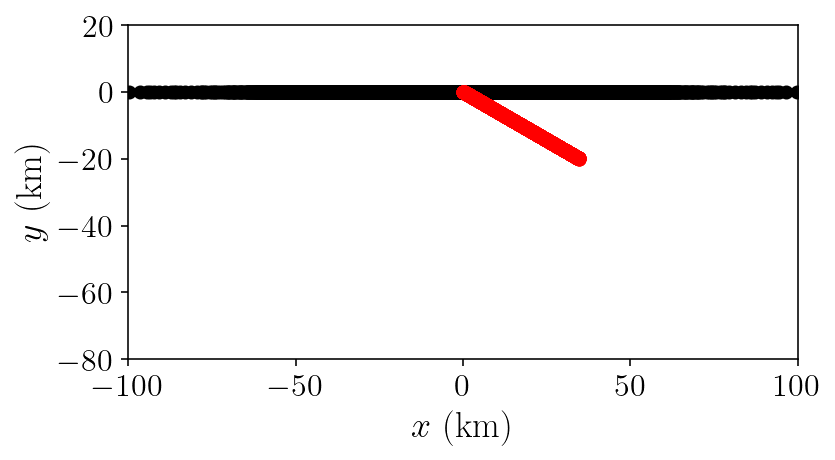

In [6]:
plt.plot(free.pts[:,0]/1000, free.pts[:,1]/1000, 'k-o')
plt.plot(fault.pts[:,0]/1000, fault.pts[:,1]/1000, 'r-o')
plt.xlabel(r'$x ~ \mathrm{(km)}$')
plt.ylabel(r'$y ~ \mathrm{(km)}$')
plt.axis('scaled')
plt.xlim([-100, 100])
plt.ylim([-80, 20])
plt.show()

And, to start off the integration, we'll construct the operators necessary for solving for free surface displacement from fault slip.

In [7]:
singularities = np.array(
    [
        [-surf_half_L, 0],
        [surf_half_L, 0],
        [0, 0],
        [float(sp_x.subs(sp_t,1)), float(sp_y.subs(sp_t,1))],
    ]
)

In [8]:
(free_disp_to_free_disp, fault_slip_to_free_disp), report = integrate_term(
    elastic_t(nu), free.pts, free, fault, singularities=singularities, safety_mode=True, return_report=True
)

Integration failed for observation point (54923.4, 0) , source panel center at: (54780.4, 0), panel_idx: 65, n_integrals: 100
Expansion center: (54923.4, -0.0956594) with expansion radius: 0.0956594
The maximum estimated coefficient error: 1.21619e-10 with tolerance: 1e-13
Integration failed for observation point (54679.3, 0) , source panel center at: (54536.3, 0), panel_idx: 66, n_integrals: 100
Expansion center: (54679.3, -0.0956594) with expansion radius: 0.0956594
The maximum estimated coefficient error: 1.01749e-10 with tolerance: 1e-13
Integration failed for observation point (-55428.2, 0) , source panel center at: (-55571.1, 0), panel_idx: 583, n_integrals: 100
Expansion center: (-55428.2, -0.0956594) with expansion radius: 0.0956594
The maximum estimated coefficient error: 1.1784e-10 with tolerance: 1e-13
Integration failed for observation point (-55672.3, 0) , source panel center at: (-55815.3, 0), panel_idx: 584, n_integrals: 100
Expansion center: (-55672.3, -0.0956594) with 

/Users/tbent/Dropbox/active/eq/tectosaur2/tectosaur2/integrate.py:201: UserWarning: Some integrals failed to converge during adaptive integration. This an indication of a problem in either the integration or the problem formulation.
  warnings.warn(


In [9]:
fault_slip_to_free_disp = fault_slip_to_free_disp.reshape((-1, 2 * fault.n_pts))
free_disp_to_free_disp = free_disp_to_free_disp.reshape((-1, 2 * free.n_pts))
free_disp_solve_mat = (
    np.eye(free_disp_to_free_disp.shape[0]) + free_disp_to_free_disp
)

In [10]:
from tectosaur2.elastic2d import ElasticH

(free_disp_to_fault_stress, fault_slip_to_fault_stress), report = integrate_term(
    ElasticH(nu, d_cutoff=8.0),
    # elastic_h(nu),
    fault.pts,
    free,
    fault,
    tol=1e-12,
    safety_mode=True,
    singularities=singularities,
    return_report=True,
)
fault_slip_to_fault_stress *= shear_modulus
free_disp_to_fault_stress *= shear_modulus

In [ ]:
A = -fault_slip_to_fault_stress.reshape((-1, 2 * fault.n_pts))
B = -free_disp_to_fault_stress.reshape((-1, 2 * free.n_pts))
C = fault_slip_to_free_disp
Dinv = np.linalg.inv(free_disp_solve_mat)
total_fault_slip_to_fault_stress = A - B.dot(Dinv.dot(C))

nx = fault.normals[:, 0]
ny = fault.normals[:, 1]
normal_mult = np.transpose(np.array([[nx, 0 * nx, ny], [0 * nx, ny, nx]]), (2, 0, 1))

total_fault_slip_to_fault_traction = np.sum(
    total_fault_slip_to_fault_stress.reshape((-1, 3, fault.n_pts, 2))[:, None, :, :, :]
    * normal_mult[:, :, :, None, None],
    axis=2,
).reshape((-1, 2 * fault.n_pts))

## Rate and state friction

In [ ]:
siay = 31556952  # seconds in a year
density = 2670  # rock density (kg/m^3)
cs = np.sqrt(shear_modulus / density)  # Shear wave speed (m/s)
Vp = 1e-9  # Rate of plate motion
sigma_n0 = 50e6  # Normal stress (Pa)

# parameters describing "a", the coefficient of the direct velocity strengthening effect
a0 = 0.01
amax = 0.025
H = 15000
h = 3000
fx = fault.pts[:, 0]
fy = fault.pts[:, 1]
fd = -np.sqrt(fx ** 2 + fy ** 2)
a = np.where(
    fd > -H, a0, np.where(fd > -(H + h), a0 + (amax - a0) * (fd + H) / -h, amax)
)

mp = MaterialProps(a=a, b=0.015, Dc=0.008, f0=0.6, V0=1e-6, eta=shear_modulus / (2 * cs))

In [ ]:
plt.figure(figsize=(3, 5))
plt.plot(mp.a, fd/1000, label='a')
plt.plot(np.full(fy.shape[0], mp.b), fd/1000, label='b')
plt.xlim([0, 0.03])
plt.ylabel('depth')
plt.legend()
plt.show()

In [ ]:
mesh_L = np.max(np.abs(np.diff(fd)))
Lb = shear_modulus * mp.Dc / (sigma_n0 * mp.b)
hstar = (np.pi * shear_modulus * mp.Dc) / (sigma_n0 * (mp.b - mp.a))
mesh_L, Lb, np.min(hstar[hstar > 0])

## Quasidynamic earthquake cycle derivatives

In [ ]:
from scipy.optimize import fsolve
import copy

init_state_scalar = fsolve(lambda S: aging_law(mp, Vp, S), 0.7)[0]
mp_amax = copy.copy(mp)
mp_amax.a=amax
tau_amax = -qd_equation(mp_amax, sigma_n0, 0, Vp, init_state_scalar)
init_state = np.log((2*mp.V0/Vp)*np.sinh((tau_amax - mp.eta*Vp) / (mp.a*sigma_n0))) * mp.a

init_tau = np.full(fault.n_pts, tau_amax)
init_sigma = np.full(fault.n_pts, sigma_n0)
init_slip_deficit = np.zeros(fault.n_pts)
init_conditions = np.concatenate((init_slip_deficit, init_state))

In [ ]:
class SystemState:

    V_old = np.full(fault.n_pts, Vp)
    state = None

    def calc(self, t, y, verbose=False):
        # Separate the slip_deficit and state sub components of the
        # time integration state.
        slip_deficit = y[: init_slip_deficit.shape[0]]
        state = y[init_slip_deficit.shape[0] :]

        # If the state values are bad, then the adaptive integrator probably
        # took a bad step.
        if np.any((state < 0) | (state > 2.0)):
            print("bad state")
            return False

        # The big three lines solving for quasistatic shear stress, slip rate
        # and state evolution
        sd_vector = np.stack((slip_deficit * -ny, slip_deficit * nx), axis=1).ravel()
        traction = total_fault_slip_to_fault_traction.dot(sd_vector).reshape((-1, 2))
        delta_sigma_qs = np.sum(traction * np.stack((nx, ny), axis=1), axis=1)
        delta_tau_qs = -np.sum(traction * np.stack((-ny, nx), axis=1), axis=1)
        tau_qs = init_tau + delta_tau_qs
        sigma_qs = init_sigma + delta_sigma_qs

        V = solve_friction(mp, sigma_qs, tau_qs, self.V_old, state)
        if not V[2]:
            print("convergence failed")
            return False

        V=V[0]
        if not np.all(np.isfinite(V)):
            print("infinite V")
            return False
        dstatedt = aging_law(mp, V, state)
        self.V_old = V

        slip_deficit_rate = Vp - V
        out = (
            slip_deficit,
            state,
            delta_sigma_qs,
            sigma_qs,
            delta_tau_qs,
            tau_qs,
            V,
            slip_deficit_rate,
            dstatedt,
        )
        self.data = out
        return self.data

In [ ]:
def plot_system_state(t, SS, xlim=None):
    """This is just a helper function that creates some rough plots of the
    current state to help with debugging"""
    (
        slip_deficit,
        state,
        delta_sigma_qs,
        sigma_qs,
        delta_tau_qs,
        tau_qs,
        V,
        slip_deficit_rate,
        dstatedt,
    ) = SS

    slip = Vp * t - slip_deficit

    fd = -np.linalg.norm(fault.pts, axis=1)

    plt.figure(figsize=(15, 9))
    plt.suptitle(f"t={t/siay}")
    plt.subplot(3, 3, 1)
    plt.title("slip")
    plt.plot(fd, slip)
    plt.xlim(xlim)

    plt.subplot(3, 3, 2)
    plt.title("slip deficit")
    plt.plot(fd, slip_deficit)
    plt.xlim(xlim)

    # plt.subplot(3, 3, 2)
    # plt.title("slip deficit rate")
    # plt.plot(fd, slip_deficit_rate)
    # plt.xlim(xlim)

    # plt.subplot(3, 3, 2)
    # plt.title("strength")
    # plt.plot(fd, tau_qs/sigma_qs)
    # plt.xlim(xlim)

    plt.subplot(3, 3, 3)
    # plt.title("log V")
    # plt.plot(fd, np.log10(V))
    plt.title("V")
    plt.plot(fd, V)
    plt.xlim(xlim)

    plt.subplot(3, 3, 4)
    plt.title(r"$\sigma_{qs}$")
    plt.plot(fd, sigma_qs)
    plt.xlim(xlim)

    plt.subplot(3, 3, 5)
    plt.title(r"$\tau_{qs}$")
    plt.plot(fd, tau_qs, 'k-o')
    plt.xlim(xlim)

    plt.subplot(3, 3, 6)
    plt.title("state")
    plt.plot(fd, state)
    plt.xlim(xlim)

    plt.subplot(3, 3, 7)
    plt.title(r"$\Delta\sigma_{qs}$")
    plt.plot(fd, delta_sigma_qs)
    plt.hlines([0], [fd[-1]], [fd[0]])
    plt.xlim(xlim)

    plt.subplot(3, 3, 8)
    plt.title(r"$\Delta\tau_{qs}$")
    plt.plot(fd, delta_tau_qs)
    plt.hlines([0], [fd[-1]], [fd[0]])
    plt.xlim(xlim)

    plt.subplot(3, 3, 9)
    plt.title("dstatedt")
    plt.plot(fd, dstatedt)
    plt.xlim(xlim)
    plt.tight_layout()

    plt.show()

In [ ]:
def calc_derivatives(state, t, y):
    """
    This helper function calculates the system state and then extracts the
    relevant derivatives that the integrator needs. It also intentionally
    returns infinite derivatives when the `y` vector provided by the integrator
    is invalid.
    """
    if not np.all(np.isfinite(y)):
        return np.inf * y
    state_vecs = state.calc(t, y)
    if not state_vecs:
        return np.inf * y
    derivatives = np.concatenate((state_vecs[-2], state_vecs[-1]))
    return derivatives

## Integrating through time

In [ ]:
%%time
from scipy.integrate import RK23, RK45

# We use a 5th order adaptive Runge Kutta method and pass the derivative function to it
# the relative tolerance will be 1e-11 to make sure that even
state = SystemState()
derivs = lambda t, y: calc_derivatives(state, t, y)
integrator = RK45
atol = Vp * 1e-6
rtol = 1e-11
rk = integrator(derivs, 0, init_conditions, 1e50, atol=atol, rtol=rtol)

# Set the initial time step to one day.
rk.h_abs = 60 * 60 * 24

# Integrate for 1000 years.
max_T = 1000 * siay

n_steps = 50000
t_history = [0]
y_history = [init_conditions.copy()]
for i in range(n_steps):
    # Take a time step and store the result
    if rk.step() != None:
        raise Exception("TIME STEPPING FAILED")
    t_history.append(rk.t)
    y_history.append(rk.y.copy())

    # Print the time every 5000 steps
    if i % 1000 == 0:
        print(f"step={i}, time={rk.t / siay} yrs, step={(rk.t - t_history[-2]) / siay}")
    # if i % 500 == 0:
    #     print(f"step={i}, time={rk.t / siay} yrs, step={(rk.t - t_history[-2]) / siay}")
    #     plot_system_state(rk.t, state.calc(rk.t, rk.y))#, xlim=[-21000, -14000])

    if rk.t > max_T:
        break

y_history = np.array(y_history)
t_history = np.array(t_history)

## Plotting the results

Now that we've solved for 1000 years of fault slip evolution, let's plot some of the results. I'll start with a super simple plot of the maximum log slip rate over time.

In [ ]:
derivs_history = np.diff(y_history, axis=0) / np.diff(t_history)[:, None]
max_vel = np.max(np.abs(derivs_history), axis=1)
plt.plot(t_history[1:] / siay, np.log10(max_vel))
plt.xlabel('$t ~~ \mathrm{(yrs)}$')
plt.ylabel('$\log_{10}(V)$')
plt.show()

And next, we'll make the classic plot showing the spatial distribution of slip over time:
- the blue lines show interseismic slip evolution and are plotted every fifteen years
- the red lines show evolution during rupture every three seconds.

In [ ]:
plt.figure(figsize=(10, 4))
last_plt_t = -1000
last_plt_slip = init_slip_deficit
event_times = []
for i in range(len(y_history) - 1):
    y = y_history[i]
    t = t_history[i]
    slip_deficit = y[: init_slip_deficit.shape[0]]
    should_plot = False

    # Plot a red line every three second if the slip rate is over 0.1 mm/s.
    if (
        max_vel[i] >= 0.0001 and t - last_plt_t > 3
    ):
        if len(event_times) == 0 or t - event_times[-1] > siay:
            event_times.append(t)
        should_plot = True
        color = "r"

    # Plot a blue line every fifteen years during the interseismic period
    if t - last_plt_t > 15 * siay:
        should_plot = True
        color = "b"

    if should_plot:
        # Convert from slip deficit to slip:
        slip = -slip_deficit + Vp * t
        plt.plot(slip, fd / 1000.0, color + "-", linewidth=0.5)
        last_plt_t = t
        last_plt_slip = slip
plt.xlim([0, np.max(last_plt_slip)])
plt.ylim([-40, 0])
plt.ylabel(r"$\textrm{z (km)}$")
plt.xlabel(r"$\textrm{slip (m)}$")
plt.tight_layout()
plt.savefig("halfspace.png", dpi=300)
plt.show()

And a plot of recurrence interval:

In [ ]:
plt.title("Recurrence interval")
plt.plot(np.diff(event_times) / siay, "k-*")
plt.xticks(np.arange(0, 10, 1))
plt.yticks(np.arange(75, 80, 0.5))
plt.xlabel("Event number")
plt.ylabel("Time between events (yr)")
plt.show()

## Comparison against SCEC SEAS results

In [ ]:
ozawa_data = np.loadtxt("ozawa7500.txt")
ozawa_slip_rate = 10 ** ozawa_data[:, 2]
ozawa_stress = ozawa_data[:, 3]

In [ ]:
t_start_idx = np.argmax(max_vel > 1e-4)
t_end_idx = np.argmax(max_vel[t_start_idx:] < 1e-6)
n_steps = t_end_idx - t_start_idx
t_chunk = t_history[t_start_idx : t_end_idx]

In [ ]:
shear_chunk = []
slip_rate_chunk = []
for i in range(n_steps):
    system_state = SystemState().calc(t_history[t_start_idx + i], y_history[t_start_idx + i])
    slip_deficit, state, delta_sigma_qs, sigma_qs, delta_tau_qs, tau_qs, V, slip_deficit_rate, dstatedt = system_state
    shear_chunk.append((tau_qs - mp.eta * V))
    slip_rate_chunk.append(V)
shear_chunk = np.array(shear_chunk)
slip_rate_chunk = np.array(slip_rate_chunk)

In [ ]:
fault_idx = np.argmax((-7450 > fd) & (fd > -7550))
VAvg = np.mean(slip_rate_chunk[:, fault_idx:(fault_idx+2)], axis=1)
SAvg = np.mean(shear_chunk[:, fault_idx:(fault_idx+2)], axis=1)

In [ ]:
fault_idx

In [ ]:
t_align = t_chunk[np.argmax(VAvg > 0.2)]
ozawa_t_align = np.argmax(ozawa_slip_rate > 0.2)

for lims in [(-1, 1), (-15, 30)]:
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(t_chunk - t_align, SAvg / 1e6, "k-o", markersize=0.5, linewidth=0.5, label='here')
    plt.plot(
        ozawa_data[:, 0] - ozawa_data[ozawa_t_align, 0],
        ozawa_stress,
        "b-*",
        markersize=0.5,
        linewidth=0.5,
        label='ozawa'
    )
    plt.legend()
    plt.xlim(lims)
    plt.xlabel("Time (s)")
    plt.ylabel("Shear Stress (MPa)")
    # plt.show()

    plt.subplot(2, 1, 2)
    plt.plot(t_chunk - t_align, VAvg, "k-o", markersize=0.5, linewidth=0.5, label='here')
    plt.plot(
        ozawa_data[:, 0] - ozawa_data[ozawa_t_align, 0],
        ozawa_slip_rate[:],
        "b-*",
        markersize=0.5,
        linewidth=0.5,
        label='ozawa'
    )
    plt.legend()
    plt.xlim(lims)
    plt.xlabel("Time (s)")
    plt.ylabel("Slip rate (m/s)")
    plt.tight_layout()
    plt.show()